# Conformal Prediction Minimal Implementation

As a basic introduction to conformal prediction, this notebook trains a simple classifier for CIFAR10 prediction, and then adds conformal prediction on top to give prediction sets.

In [44]:
import jax
import torch
import numpy as np
import jax.numpy as jnp
import flax.linen as nn

from einops import rearrange
from pprint import pprint
from torch.utils.data import default_collate, DataLoader
from torchvision.datasets import CIFAR10

In [45]:
# TRAIN = False

## Pull in the data and transform it

In [46]:
def pil_to_tensor(img):
    """Convert a PIL Image to a JAX array scaled to [0,1], shape (HxWxC)"""
    return torch.tensor(np.array(img), dtype=torch.float32) / 255.0

def numpy_collate(batch):
  "Convert a batch of torch tensors to jnp arrays"
  return jax.tree.map(jnp.asarray, default_collate(batch))

def one_hot(batch):
   "One hot encode integer labels"
   batch = torch.tensor(batch)
   return torch.nn.functional.one_hot(batch, num_classes=10)

dataset_gen = torch.Generator().manual_seed(42)

trainvalset = CIFAR10(download=True, root='../data/', train=True, transform=pil_to_tensor, target_transform=one_hot)
testset = CIFAR10(download=True, root='../data/', train=False, transform=pil_to_tensor, target_transform=one_hot)
# split out a validation set
trainset = torch.utils.data.Subset(trainvalset, indices=range(40_000))
valset = torch.utils.data.Subset(trainvalset, indices=range(40_000, 50_000))
# convert to dataloaders for training
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, generator=dataset_gen, collate_fn=numpy_collate)
valloader = DataLoader(valset, batch_size=64, shuffle=True, generator=dataset_gen, collate_fn=numpy_collate)
testloader = DataLoader(testset, batch_size=64, shuffle=True, generator=dataset_gen, collate_fn=numpy_collate)

## Define and instantiate the model

In [47]:
class CIFARClassifier(nn.Module):
    """Minimal CNN for CIFAR-10."""
    num_classes: int = 10

    @nn.compact
    def __call__(self, x: jnp.ndarray, *, train: bool = True) -> jnp.ndarray:
        # Block 1
        x = nn.Conv(32, (3, 3), padding='VALID')(x)      # 32×32 → 30×30, 32 ch
        x = nn.relu(x)
        x = nn.Conv(64, (3, 3), padding='VALID')(x)      # 30×30 → 28×28, 64 ch
        x = nn.relu(x)
        x = nn.avg_pool(x, (2, 2), (2, 2))  # 28×28 → 14×14

        # Block 2
        x = nn.Conv(128, (3, 3), padding='VALID')(x)     # 14×14 → 12×12, 128 ch
        x = nn.relu(x)
        x = nn.avg_pool(x, (2, 2), (2, 2))  # 12×12 → 6×6

        # Head
        x = rearrange(x, 'b h w d -> b (h w d)')     # flatten: 6×6×128 = 4608
        x = nn.Dense(256)(x)
        x = nn.relu(x)
        x = nn.Dropout(0.5, deterministic=not train)(x)
        x = nn.Dense(self.num_classes)(x)   # logits shape: (batch, 10)
        return x

In [48]:
for x, y in trainloader:
    break

assert type(x) is type(y) is type(jnp.ones(5))
print(f'x:{x.shape}, y:{y.shape}')

x:(64, 32, 32, 3), y:(64, 10)


In [49]:
key = jax.random.key(42)
key, subkey = jax.random.split(key)

model = CIFARClassifier()

params = model.init(subkey, x)
pprint(jax.tree.map(jnp.size, params), underscore_numbers=True)

{'params': {'Conv_0': {'bias': 32, 'kernel': 864},
            'Conv_1': {'bias': 64, 'kernel': 18_432},
            'Conv_2': {'bias': 128, 'kernel': 73_728},
            'Dense_0': {'bias': 256, 'kernel': 1_179_648},
            'Dense_1': {'bias': 10, 'kernel': 2_560}}}


## Train the image classifier

In [ ]:
import optax
from flax.training.train_state import TrainState

n_epochs = 10
lr = 1e-3
dropout_key = jax.random.key(42)

tx = optax.adamw(lr)
state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state: TrainState, x, y, dropout_rng):
    def loss_fn(params: jnp.ndarray):
        logits = state.apply_fn(params, x, rngs={'dropout': dropout_rng})
        return optax.softmax_cross_entropy(logits, y).mean()
    
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return loss, state

@jax.jit
def eval_step(state: TrainState, x: jnp.ndarray, y: jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Performs a single evaluation step."""
    # Pass `train=False` to disable dropout
    logits = state.apply_fn(state.params, x, train=False)
    loss = optax.softmax_cross_entropy(logits, y).mean()
    accuracy = jnp.mean(jnp.argmax(logits, -1) == y.argmax(-1))
    return loss, accuracy

epoch_stats = []
for epoch in range(n_epochs):
    print(f'--- Epoch {epoch+1}')
    batch_losses = []
    for x, y in trainloader:
        dropout_key, subkey = jax.random.split(dropout_key)
        batch_loss, state = train_step(state, x, y, subkey)
        batch_losses.append(batch_loss)

    # calculate the validation loss
    # --- Evaluate on validation set ---
    val_losses = []
    val_accuracies = []
    for x, y in valloader:
        val_loss_batch, val_acc_batch = eval_step(state, x, y)
        val_losses.append(val_loss_batch)
        val_accuracies.append(val_acc_batch)
    # --- Compute average metrics for the epoch ---

    print(f'  Train loss:              {np.mean(batch_losses):.4f}')
    print(f'  Validation loss:         {np.mean(val_losses):.4f}')
    print(f'  Validation accuracy:     {np.mean(val_accuracies):.4f}\n')
    epoch_stats = {'batch_losses': batch_losses, 'val_loss': np.mean(val_losses), 'val_accuracy': np.mean(val_accuracies)}

--- Epoch 1
  Train loss:              1.5701
  Validation loss:         1.2804
  Validation accuracy:     0.5410

--- Epoch 2
  Train loss:              1.2052
  Validation loss:         1.0219
  Validation accuracy:     0.6450

--- Epoch 3
  Train loss:              1.0274
  Validation loss:         0.9148
  Validation accuracy:     0.6783

--- Epoch 4


In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(batch_losses)

### Save the trained model

In [ ]:
import orbax.checkpoint as ocp
from flax.training import orbax_utils
from os.path import abspath
# Directory to save the final model parameters
model_dir = './checkpoints/my_trained_model'
model_dir = abspath(model_dir)

# Create a checkpointer
param_checkpointer = ocp.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state.params)

# Save only the parameters from the TrainState
param_checkpointer.save(model_dir, state.params, save_args=save_args, force=True)

### Load a trained model

In [ ]:
loaded_params = param_checkpointer.restore(model_dir)

/Users/alexinch/Desktop/noodling/msc_thesis/.venv/lib/python3.13/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1251: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


# Conformal Prediction

## Build a calibration set

In [ ]:
n_calibration = 400
alpha = 0.1

calibration_set = torch.utils.data.Subset(testset, range(n_calibration))
calibration_loader = DataLoader(calibration_set, batch_size=64, shuffle=True, generator=dataset_gen, collate_fn=numpy_collate)

In [ ]:
# Calculate the logits for all the examples in the calibration set
all_scores = []
for x, y in calibration_loader:
    logits = model.apply(loaded_params, x, train=False)
    probs = nn.softmax(logits)
    true_classes = y.argmax(-1)
    # select the model's predicted probability for the true class, for each example in the batch
    batch_scores = 1 - probs[range(len(true_classes)), true_classes]
    all_scores.append(batch_scores)

all_scores = jnp.concat(all_scores)
q_level = jnp.ceil((n_calibration+1)*(1-alpha)) / n_calibration
qhat = jnp.quantile(all_scores, q_level, method='higher')

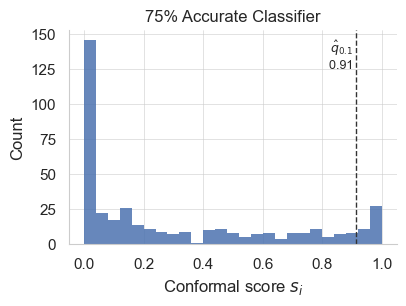

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

def plot_conformal_hist(scores, qhat, accuracy=0.75, alpha=0.1):
    """
    Histogram of conformal scores with the empirical quantile line.
    
    Parameters
    ----------
    scores : 1-D array-like
        Conformal scores s_i.
    qhat : float
        Estimated (1 - α) quantile of scores.
    accuracy : float, optional
        Reported model accuracy for the title. Default is 0.75 (→ “75%”).
    """
    sns.set_theme(style="whitegrid", rc={
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.edgecolor": ".8",
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.4,
    })

    fig, ax = plt.subplots(figsize=(4, 3))

    # Histogram (step-filled, light edge)
    sns.histplot(
        scores,
        bins=25,
        ax=ax,
        kde=False,
        stat="count",
        edgecolor=".1",
        linewidth=0.0,
        alpha=0.85
    )

    # Quantile reference line
    ax.axvline(qhat, ls="--", lw=1, c=".2")
    ymax = ax.get_ylim()[1]
    ax.text(qhat - 0.01, 0.96 * ymax,
            rf"""$\hat{{q}}_{{{alpha}}}$
            {qhat:.2f}""",
            ha="right", va="top", fontsize=9)

    # Labels and title
    ax.set_xlabel(r"Conformal score $s_i$")
    ax.set_ylabel("Count")
    ax.set_title(f"{int(accuracy * 100)}% Accurate Classifier", pad=6)

    fig.tight_layout(pad=0.4)
    return fig

# --- usage example ---
fig = plot_conformal_hist(all_scores, qhat, alpha=alpha)

# e.g., “_20250610_143259”
suffix = time.strftime("_%Y%m%d_%H%M%S")
figure_dir = '../results/figures/basic_conformal_prediction'
# fig.savefig(f"{figure_dir}/conformal_hist_seaborn_{suffix}.pdf", dpi=300, bbox_inches="tight")

## Conformal Prediction Examples

In [ ]:
i = 0

trues = 0
prediction_sets = []
for x_test, y_test in testloader:
    # skip the examples uesd in the calibration set
    i += 64
    if i <= n_calibration:
        continue

    logits = model.apply(loaded_params, x_test, train=False)
    probs = nn.softmax(logits)
    scores = 1 - probs
    # now select the relevant classes
    prediction_set = scores <= qhat
    indices = jnp.argwhere(prediction_set)

    for idx in range(len(x_test)):
        predictions = indices[indices[:, 0] == idx][:, 1]
        true_class = y_test[idx].argmax()
        if true_class in predictions:
            trues += 1
        
        prediction_sets.append(predictions)

# check the accuracy rate
valid_rate = trues / (len(testset) - n_calibration)
print(f'Proportion of prediction sets containing the true prediction: {valid_rate:.5f}')
print(f'                                                   1 - alpha: {1 - alpha:.5f}')

Proportion of prediction sets containing the true prediction: 0.90521
                                                   1 - Alpha: 0.90000


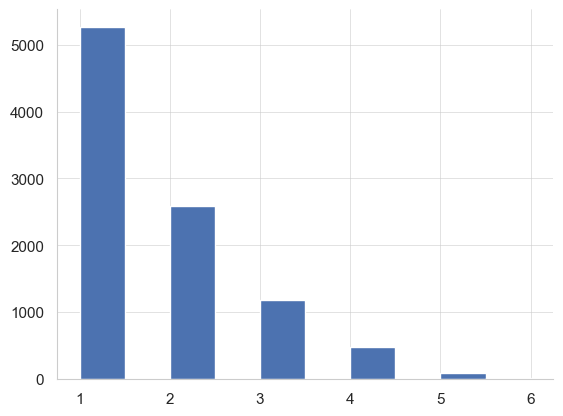

In [ ]:
prediction_set_sizes = jnp.array(jax.tree.map(jnp.size, prediction_sets))
plt.hist(prediction_set_sizes);

In [ ]:
from PIL import Image

def jax_to_pil(img_jnp):
    """Convert a JAX array (C, H, W) in [0,1] back to a PIL Image."""
    img = img_jnp * 255.0
    img = jnp.clip(img, 0, 255).astype(jnp.uint8)
    np_img = np.array(img)
    return Image.fromarray(np_img)

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Prediction Set: {deer, truck}
True Class: truck


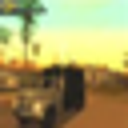

In [ ]:
idx = 9
pred_str = ', '.join([classes[c] for c in prediction_sets[-16+idx]])
print(f'Prediction Set: {{{pred_str}}}')
print(f'True Class: {classes[y_test[idx].argmax()]}')
img = jax_to_pil(x_test[idx])
img.resize(size=(128, 128))

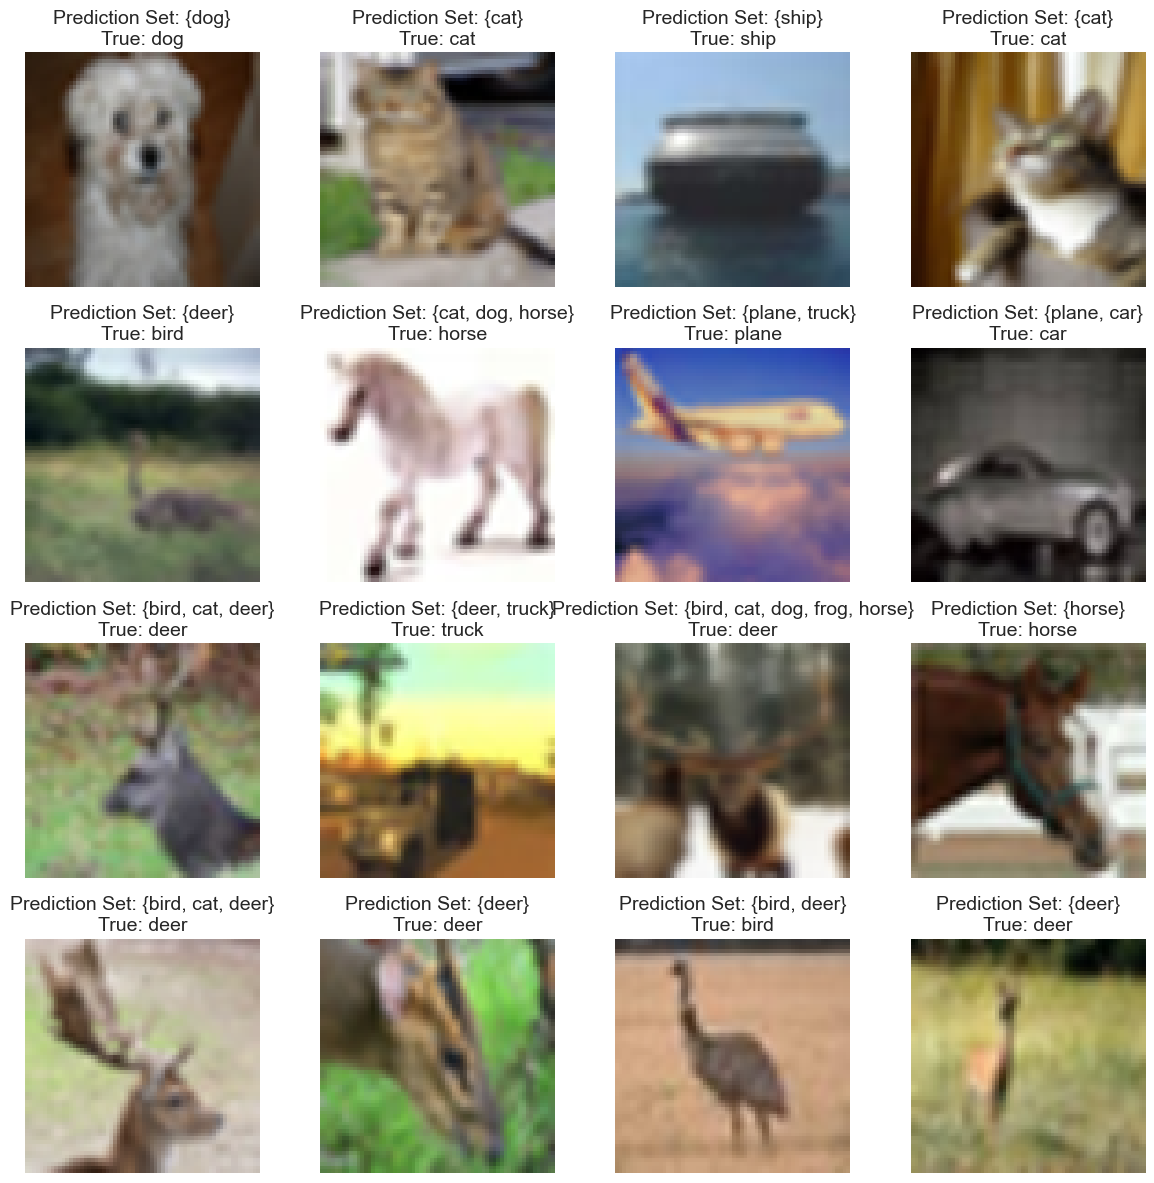

In [ ]:
import matplotlib.pyplot as plt

def plot_prediction_grid(x_test, y_test, prediction_sets, classes, indices=range(16)):
    """
    Show a 4×4 grid of images with their prediction sets and true labels.

    Parameters
    ----------
    x_test : array-like
        Input images.
    y_test : array-like
        One-hot true labels.
    prediction_sets : sequence of sequences
        Model’s prediction sets, aligned with x_test. The slice [-16:] is kept
        to match your original indexing.
    classes : list[str]
        Mapping from label index to class name.
    jax_to_pil : Callable
        Function converting a JAX/NumPy image to a PIL Image.
    indices : iterable[int], default range(16)
        Indices to plot. Must have length ≤ 16 to fit a 4×4 grid.

    Returns
    -------
    matplotlib.figure.Figure
        The generated figure (useful for saving or further tweaking).
    """
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        # image
        img = jax_to_pil(x_test[idx])
        ax.imshow(img.resize((64, 64)))
        ax.axis("off")

        # text
        pred_str = ", ".join(classes[c] for c in prediction_sets[-16 + idx])
        true_cls = classes[y_test[idx].argmax()]
        ax.set_title(f"Prediction Set: {{{pred_str}}}\nTrue: {true_cls}", fontsize=14)

    # Hide unused axes if <16 indices
    for ax in axes[len(indices):]:
        ax.axis("off")

    plt.tight_layout()
    return fig

fig = plot_prediction_grid(x_test, y_test, prediction_sets, classes)
plt.show()    # or fig.savefig("pred_grid.png", dpi=300)